In [1]:
import numpy as np
import pandas as pd
import keijzer_exogan as ke
import glob
import copy
import seaborn as sns
import math

import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import Pool

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

In [2]:
#path = '/datb/16011015/MakeAI' #datascience server
path = '/shared/datasets/16011015/MakeAI_SURFsara/*/*/' # gpu server

# file paths
trans_ = glob.glob(path+'/*/trans')
params_ = glob.glob(path+'/*/parameters')
ariels = glob.glob(path+'/*/contr_trans_ARIEL')

In [3]:
len(trans_)

143356

In [4]:
data = [(trans_[i], params_[i], ariels[i]) for i in tqdm(range(len(trans_)))]

100%|██████████| 143356/143356 [00:00<00:00, 1122335.03it/s]


In [5]:
def f(t):
    try: # some models got weird text like 123-58 in there, so got to catch errors like that and not process them. 
        trans_file, params_file, ariels_file = t
        aspa = ke.ASPA_complex_v1(trans_file, params_file, ariels_file)
        aspa = aspa.reshape(1,32,32)
    except:
        aspa = None
    return aspa

In [6]:
%%time
pool = Pool() # server has 2x 12 cores -> Pool(processes=24)
results = pool.map(f, data, chunksize=1)

/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:705: RuntimeWarning: divide by zero encountered in log10
  params[key] = np.log10(params[key])
/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:705: RuntimeWarning: divide by zero encountered in log10
  params[key] = np.log10(params[key])
/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:705: RuntimeWarning: divide by zero encountered in log10
  params[key] = np.log10(params[key])
/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:705: RuntimeWarning: divide by zero encountered in log10
  params[key] = np.log10(params[key])


CPU times: user 10.7 s, sys: 3.88 s, total: 14.5 s
Wall time: 14min 58s


In [19]:
%%time
pool.close()
pool.join()
pool.terminate() # not nice but meh, pool.join() gets stuck... https://stackoverflow.com/questions/15314189/python-multiprocessing-pool-hangs-at-join

CPU times: user 0 ns, sys: 158 µs, total: 158 µs
Wall time: 167 µs


In [20]:
#results incl. errors
len(results)

143356

In [21]:
# results without errors
aspas = [result for result in results if result is not None] # Only select the not-none items (so the ones without errors)

len(aspas)

122096

In [22]:
%%time 
images = np.array(aspas)

CPU times: user 275 ms, sys: 585 ms, total: 860 ms
Wall time: 858 ms


In [23]:
# results without errors
images = [aspa for aspa in images if (not np.isnan(aspa).any() and not np.isinf(aspa).any())] # remove aspa's with NaNs

len(images)

121309

In [24]:
%%time 
images = np.array(images)

CPU times: user 258 ms, sys: 582 ms, total: 840 ms
Wall time: 839 ms


In [25]:
%%time
np.random.shuffle(images)

np.save('/shared/datasets/16011015/MakeAI_SURFsara//ASPAs/MakeAI_train_complex.npy', images[:10**5])
np.save('/shared/datasets/16011015/MakeAI_SURFsara/ASPAs/MakeAI_test_complex.npy', images[10**5:])

CPU times: user 569 ms, sys: 993 ms, total: 1.56 s
Wall time: 3.45 s


# Visualize

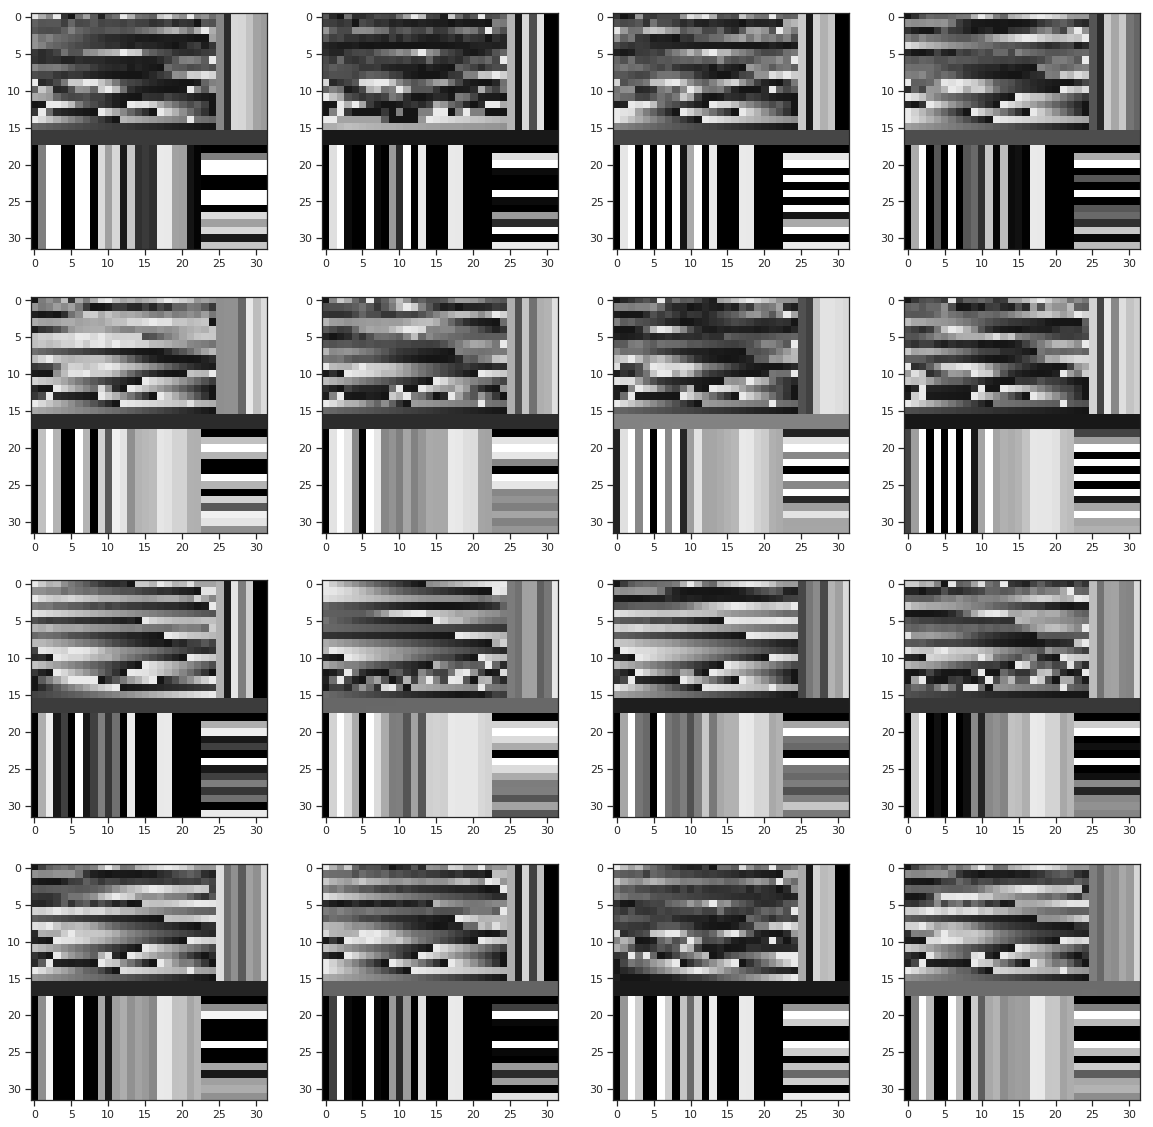

In [16]:
plt.figure(figsize=(20,20))

for i in range(4*4):
    aspa = images[i, 0]
    plt.subplot(4,4,i+1)
    plt.imshow(aspa, cmap='gray', vmin=-1.2, vmax=1.2)

# Checking saved file

In [11]:
train = np.load('/shared/datasets/16011015/MakeAI_SURFsara//ASPAs/MakeAI_train_complex.npy')
train.shape

(100000, 1, 32, 32)

In [16]:
inans = []

for i in range(len(train)):
    aspa = train[i]
    
    if np.isnan(aspa).any():
        inans.append(i)

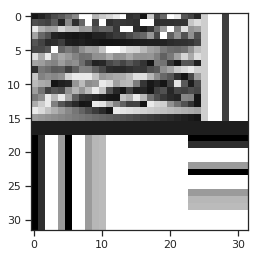

In [23]:
aspa = train[108, 0]
plt.imshow(aspa, cmap='gray', vmin=-1.2, vmax=1.2)

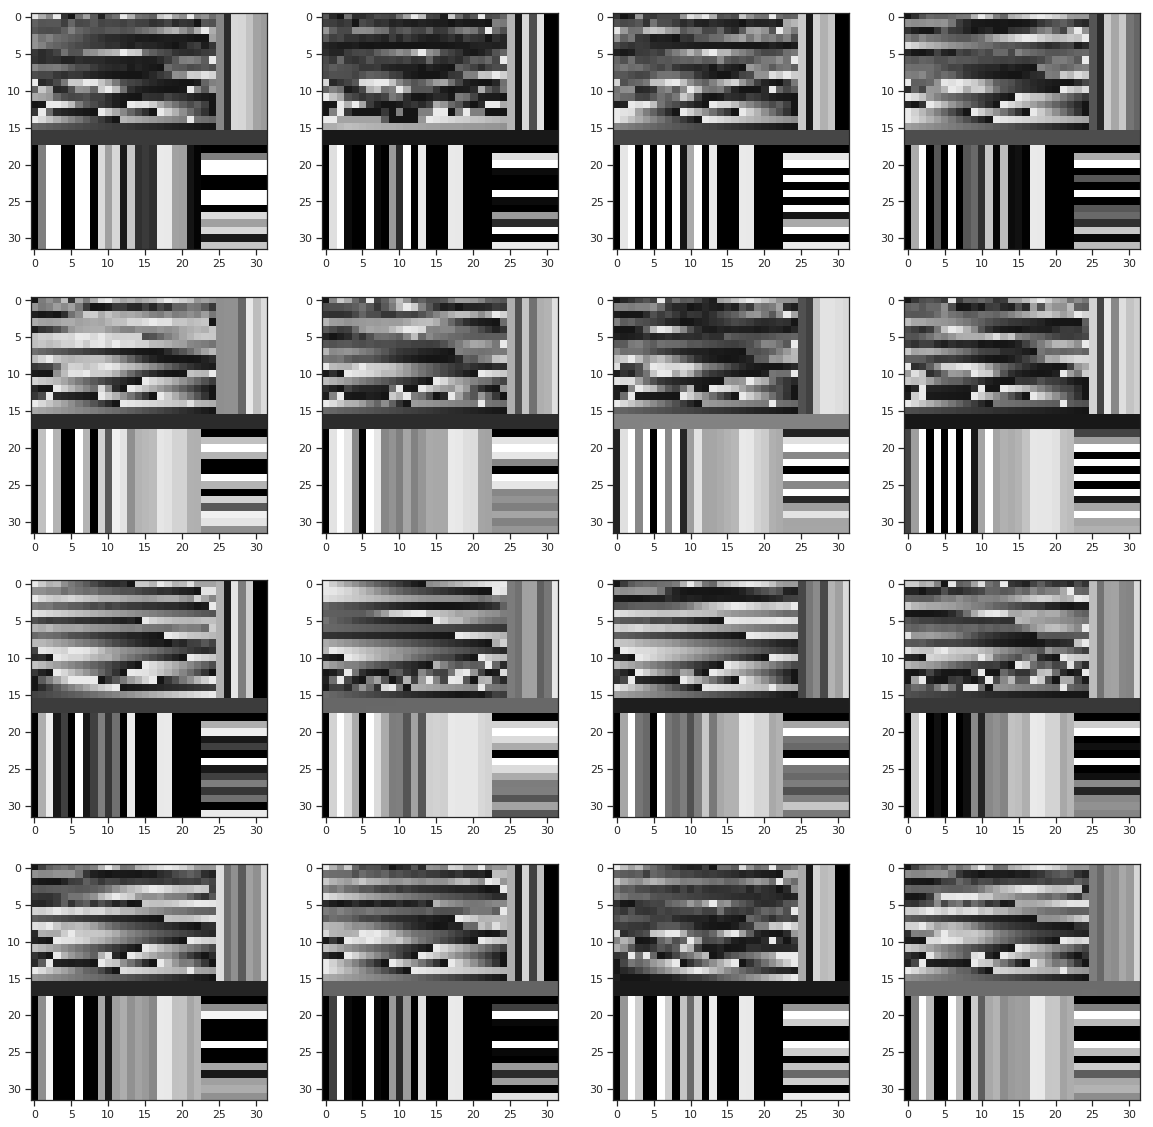

In [18]:
plt.figure(figsize=(20,20))

for i in range(4*4):
    aspa = train[i, 0]
    plt.subplot(4,4,i+1)
    plt.imshow(aspa, cmap='gray', vmin=-1.2, vmax=1.2)